In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from tqdm import tqdm
import copy

In [2]:
import glob
import time 
import torch
from joblib import Parallel, delayed 

In [8]:

# train = pd.read_csv('inputs/train.csv')
train_correcetd =  pd.read_csv('inputs/train_corrected_kfold.csv')

In [9]:
train_correcetd.kfold.value_counts()

0    28997
2    28968
3    28904
1    28737
4    28687
Name: kfold, dtype: int64

In [10]:
train_correcetd[train_correcetd.id=="62C57C524CD2"]

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
73038,62C57C524CD2,1.617199e+12,0,67,I think we should be able to play in a sport i...,Position,Position 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16,4
73039,62C57C524CD2,1.617199e+12,67,157,I think i would be not fear for student that h...,Evidence,Evidence 1,17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 3...,4
73040,62C57C524CD2,1.617199e+12,157,203,If we had a D or an F i would understand that,Counterclaim,Counterclaim 1,38 39 40 41 42 43 44 45 46 47 48 49,4
73041,62C57C524CD2,1.617199e+12,203,222,but a C i nothing.,Rebuttal,Rebuttal 1,50 51 52 53 54,4
73042,62C57C524CD2,1.617199e+12,222,415,Not a lot of kid get A or Bs and if we do. Som...,Evidence,Evidence 2,55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 7...,4
73043,62C57C524CD2,1.617199e+12,415,594,If there is only 1 out of 4 percent of student...,Claim,Claim 1,100 101 102 103 104 105 106 107 108 109 110 11...,4
73044,62C57C524CD2,1.617199e+12,594,665,that means you would have to cancel all the sp...,Evidence,Evidence 3,140 141 142 143 144 145 146 147 148 149 150 15...,4
73045,62C57C524CD2,1.617199e+12,665,715,That why you should let C student play an a sp...,Concluding Statement,Concluding Statement 1,154 155 156 157 158 159 160 161 162 163 164,4


In [12]:
# train['length_of_text'] = train['discourse_text'].apply(lambda x: len(x.split()))

In [13]:
train_correcetd.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8,230,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230,313,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759,887,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1


In [14]:
def agg_essays(train_flg):
    folder = 'train' if train_flg else 'test'
    names, texts =[], []
    for f in tqdm(glob.glob(f'inputs/{folder}/*.txt')):
        names.append(f.split('/')[-1].replace('.txt', ''))
        texts.append(open(f, 'r').read())
        

    df_texts = pd.DataFrame({'id': names, 'text': texts})
    df_texts['text_split'] = df_texts.text.str.split()
    print('Completed tokenizing texts.')
    return df_texts



In [15]:
def ner(df_texts, df_train):
    all_entities = []
    for _,  row in tqdm(df_texts.iterrows(), total=len(df_texts)):
        total = len(row['text_split'])
        entities = ['0'] * total

        for _, row2 in df_train[df_train['id'] == row['id']].iterrows():
            discourse = row2['discourse_type']
            list_ix = [int(x) for x in row2['predictionstring'].split(' ')]
            entities[list_ix[0]] = f'B-{discourse}'
            for k in list_ix[1:]: entities[k] = f'I-{discourse}'
        all_entities.append(entities)

    df_texts['entities'] = all_entities
    print('Completed mapping discourse to each token.')
    return df_texts


In [16]:
def prepare_data1(df,df_train, inference=False):
    samples = []
    ids = df["id"].unique()

    ids_splits = np.array_split(ids, 4)
    # multiprocessing
    results = Parallel(n_jobs=4, backend="multiprocessing")(
        delayed(ner)(df[df.id.isin(idx)], df_train[df_train.id.isin(idx)]) for idx in ids_splits
    )
#     for result in results:
#         samples.extend(result)
    samples = pd.concat(results)

    return samples


In [20]:
cc = prepare_data1(df_texts,train_correcetd, inference=False)

 98%|█████████▊| 3811/3899 [00:22<00:00, 173.20it/s]

Completed mapping discourse to each token.


 96%|█████████▌| 3738/3898 [00:22<00:00, 167.18it/s]

Completed mapping discourse to each token.


 98%|█████████▊| 3825/3898 [00:22<00:00, 169.00it/s]

Completed mapping discourse to each token.


100%|██████████| 3898/3898 [00:22<00:00, 169.70it/s]


Completed mapping discourse to each token.


In [23]:
cc

,id,text,text_split,entities,length
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ...","[B-Position, I-Position, I-Position, I-Positio...",617
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,...","[0, 0, B-Position, I-Position, I-Position, I-P...",328
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",461
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",385
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",334
...,...,...,...,...,...
15589,44A73349B60A,"When looking for advice on a decision, do you ...","[When, looking, for, advice, on, a, decision,,...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",758
15590,0C8E8861F91A,I agree with the claim against the value of us...,"[I, agree, with, the, claim, against, the, val...","[B-Position, I-Position, I-Position, I-Positio...",262
15591,6E534D6E2282,Some people like to drive while otherss don't ...,"[Some, people, like, to, drive, while, otherss...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",455
15592,A2A4548C52DA,"Phones have come a very long way since 1973, p...","[Phones, have, come, a, very, long, way, since...","[B-Lead, I-Lead, I-Lead, I-Lead, I-Lead, I-Lea...",510


<AxesSubplot:>

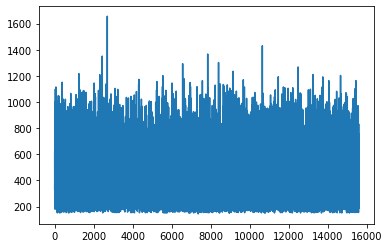

In [24]:
cc.length.plot()

In [22]:
cc['length'] = cc['text_split'].apply(lambda x: len(x))

In [18]:
df_texts = agg_essays("train")

100%|██████████| 15594/15594 [00:00<00:00, 35240.35it/s]


Completed tokenizing texts.


In [19]:
df_texts.head()

,id,text,text_split
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ..."
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,..."
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id..."
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la..."
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo..."


In [64]:
target_id_map = {
    "B-Lead": 0,
    "I-Lead": 1,
    "B-Position": 2,
    "I-Position": 3,
    "B-Evidence": 4,
    "I-Evidence": 5,
    "B-Claim": 6,
    "I-Claim": 7,
    "B-Concluding Statement": 8,
    "I-Concluding Statement": 9,
    "B-Counterclaim": 10,
    "I-Counterclaim": 11,
    "B-Rebuttal": 12,
    "I-Rebuttal": 13,
    "O": 14,
    "PAD": -100,
}


id_target_map = {v: k for k, v in target_id_map.items()}

In [65]:
id_target_map

{0: 'B-Lead',
 1: 'I-Lead',
 2: 'B-Position',
 3: 'I-Position',
 4: 'B-Evidence',
 5: 'I-Evidence',
 6: 'B-Claim',
 7: 'I-Claim',
 8: 'B-Concluding Statement',
 9: 'I-Concluding Statement',
 10: 'B-Counterclaim',
 11: 'I-Counterclaim',
 12: 'B-Rebuttal',
 13: 'I-Rebuttal',
 14: 'O',
 -100: 'PAD'}

In [66]:
def _prepare_data_helper(tokenizer, df, ids,inference=False):
    samples = []
#     folder_ = "test" if inference else "train"
    folder_ =  "train"
    
    for idx in tqdm(ids):
        filename = os.path.join(config.TEXT_PATH, folder_ , idx + ".txt")
        with open(filename, "r") as f:
            try:
                text = f.read()
            except UnicodeDecodeError as e :
#                 if isinstance(text, bytes):
                print(idx,"????????????????????????")
                

        encoded_text = tokenizer.encode_plus(
            text,
#             text.split(),
#             is_split_into_words = True,
            add_special_tokens=False,
            return_offsets_mapping=True,
        )
        input_ids = encoded_text["input_ids"]
        input_labels = copy.deepcopy(input_ids)
        offset_mapping = encoded_text["offset_mapping"]

        for k in range(len(input_labels)):
            input_labels[k] = "O"

        sample = {
            "id": idx,
            "input_ids": input_ids,
            "text": text,
            "offset_mapping": offset_mapping,
        }
        
        if inference:
            samples.append(sample)
            
        else:
                  
            temp_df = df[df["id"] == idx]
            for _, row in temp_df.iterrows():
                text_labels = [0] * len(text)
                discourse_start = int(row["discourse_start"])
                discourse_end = int(row["discourse_end"])
                prediction_label = row["discourse_type"]
                text_labels[discourse_start:discourse_end] = [1] * (discourse_end - discourse_start)
                target_idx = []
                for map_idx, (offset1, offset2) in enumerate(encoded_text["offset_mapping"]):
                    if sum(text_labels[offset1:offset2]) > 0:
                        if len(text[offset1:offset2].split()) > 0:
                            target_idx.append(map_idx)

                targets_start = target_idx[0]
                targets_end = target_idx[-1]
                pred_start = "B-" + prediction_label
                pred_end = "I-" + prediction_label
                input_labels[targets_start] = pred_start
                input_labels[targets_start + 1 : targets_end + 1] = [pred_end] * (targets_end - targets_start)

            sample["input_ids"] = input_ids
            sample["input_labels"] = input_labels
            samples.append(sample)
    
    return samples


def prepare_data(df, tokenizer,inference=False):
    samples = []
    ids = df["id"].unique()

    ids_splits = np.array_split(ids, config.NJOBS)
#     multiprocessing
    results = Parallel(n_jobs=config.NJOBS, backend="multiprocessing")(
        delayed(_prepare_data_helper)(tokenizer, df, idx,inference=inference) for idx in ids_splits
    )
    for result in results:
        samples.extend(result)

    return samples

In [3]:
import config
import preprocessing
import dataset
from transformers import AutoTokenizer

2022-03-06 10:53:12.806148: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [12]:
tokenizer = AutoTokenizer.from_pretrained("model_obj/longformer-base-4096/")

In [132]:
tokenizer

PreTrainedTokenizerFast(name_or_path='model_obj/longformer-base-4096/', vocab_size=50265, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [30]:
sen="my name is surajajaaja, I am a good boy"

In [124]:
inputs = tokenizer.encode_plus(
            sen,
            add_special_tokens=False,
            return_offsets_mapping=True,
        )

In [40]:
inputs

{'input_ids': [4783, 766, 16, 8113, 1176, 10737, 10737, 6, 38, 524, 10, 205, 2143], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 2), (3, 7), (8, 10), (11, 14), (14, 16), (16, 19), (19, 22), (22, 23), (24, 25), (26, 28), (29, 30), (31, 35), (36, 39)]}

In [36]:
tokenizer.encode('<unk>')

[0, 3, 2]

In [108]:
tokenizer.decode([4783])

'my'

In [125]:
inputs.input_ids

[4783, 766, 16, 8113, 1176, 10737, 10737, 6, 38, 524, 10, 205, 2143]

In [131]:
inputs.input_ids

[4783, 766, 16, 8113, 1176, 10737, 10737, 6, 38, 524, 10, 205, 3]

In [127]:
rand

tensor([0.4121, 0.5666, 0.9258, 0.4450, 0.9222, 0.8898, 0.9038, 0.2344, 0.4462,
        0.3096, 0.9525, 0.5604, 0.1456])

In [128]:
mask_arr

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True])

In [129]:
masked_selection = [int(mask_arr[i]) for i in range(len(mask_arr))]


In [130]:
for idx, selection in enumerate(masked_selection):
    if masked_selection[idx]==1:
         inputs.input_ids[idx] = 3

In [126]:
rand = torch.rand(len(inputs.input_ids))
# where the random array is less than 0.10, we set true
mask_arr = (rand < 0.2) * (inputs.input_ids != 0) * (inputs.input_ids != 2)

# masked_selection = [torch.flatten((mask_arr[i]).nonzero()).tolist() for i in range(len(mask_arr))]

# # create selection from mask_arr
# # apply selection index to inputs adding MASK tokens
# for idx, selection in enumerate(masked_selection):
#     input_ids[idx, selection] = 3

In [123]:
masked_selection

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]

In [37]:
tokenizer.decode([0,3,2])

'<s><unk></s>'

In [69]:
tokenizer

PreTrainedTokenizerFast(name_or_path='model_obj/longformer-base-4096/', vocab_size=50265, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='google/bigbird-roberta-large', vocab_size=50358, model_max_len=4096, is_fast=True, padding_side='right', special_tokens={'bos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [14]:
train_set = train_correcetd[train_correcetd.kfold==0]  #"423A1CA112E2", 'A8445CABFECE', ,'4C471936CD75'

In [15]:
valid_set_ = train_correcetd[train_correcetd.kfold==1]

In [16]:
valid_set_ = valid_set_[valid_set_.id=='423A1CA112E2']

In [17]:
train_set.reset_index(drop=True,inplace=True)
valid_set_.reset_index(drop=True,inplace=True)

In [18]:
valid_set_

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8,230,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230,313,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759,887,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1
5,423A1CA112E2,1.622628e+12,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,1
6,423A1CA112E2,1.622628e+12,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,1
7,423A1CA112E2,1.622628e+12,1534,1603,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,1
8,423A1CA112E2,1.622628e+12,1603,1891,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,1
9,423A1CA112E2,1.622628e+12,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,1


In [18]:
# import os
# os.environ['TOKENIZERS_PARALLELISM']= "True"

In [19]:
print(f"Preprocessing the Train data")
train_set = preprocessing.prepare_data1(df_texts[df_texts.id.isin(train_set.id)],train_set,tokenizer)

print(f"Preprocessing the Valid data")
valid_set = preprocessing.prepare_data1(df_texts[df_texts.id.isin(valid_set_.id)],valid_set_,tokenizer)


Preprocessing the Train data


100%|██████████| 389/389 [00:03<00:00, 119.57it/s]


Preprocessing the Valid data


100%|██████████| 1/1 [00:00<00:00, 51.47it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [19]:
valid_set_A= prepare_data(valid_set_, tokenizer)

100%|██████████| 1/1 [00:00<00:00, 63.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [20]:
valid_set_A_i= prepare_data(valid_set_, tokenizer,inference=True)

100%|██████████| 1/1 [00:00<00:00, 96.03it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [21]:
collate = preprocessing.Collate(tokenizer=tokenizer)

In [22]:
valid_dataloader_a = dataset.Datasetloader(samples=valid_set_A_i,tokenizer=tokenizer ,max_len= config.MAX_SEQ_LEN  , test=False,inference=True,collate= collate).fetch(
    batch_size=2, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)


In [23]:
next(iter(valid_dataloader_a))

{'ids': tensor([[    0,  4129,  6909, 50118, 50118, 39631,  5868,   452,    32,   460,
             15,    49,  1028,     4,   252,    32,   460,    15,    49,  1028,
             55,    87,   195,   722,    10,   183,   117,   912,   479,  3684,
             51,   109,    16,  2788,   124,     8,   556,     8,    95,    33,
            333,   732,  2923,    15,   592,   433,     4,   252,   190,   109,
             24,   150,  1428,     4,   252,    32,   103,   269,  1099,  4914,
             77,  2682,  2594,    77,    24,   606,     7,    10,  1028,     4,
            993,  1402,   911,    11,     5,   315,   532,  2020,  4247,    31,
           1380,  5351,    95,   142,     9,    24,     4, 50118, 50118,  1779,
             82,    33,  4247,     6,    51,   216,    59,  1402,  3798,    14,
             51,    33,   479, 46036,   101,   622,   599,  1838,     8, 11477,
              4,   407,   101,   114,    10,  1441,  3136,   409,     8,    47,
            236,     7,    28,   

In [23]:
for k,v in valid_set_A_i[0].items(): print(k,">>",len(v))

id >> 12
input_ids >> 445
text >> 2030
offset_mapping >> 445


In [24]:
for k,v in valid_set_A_i[0].items(): print(k,">>",len(v))

id >> 12
input_ids >> 445
text >> 2030
offset_mapping >> 445


In [25]:
valid_set_

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8,230,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230,313,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759,887,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1
5,423A1CA112E2,1.622628e+12,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,1
6,423A1CA112E2,1.622628e+12,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,1
7,423A1CA112E2,1.622628e+12,1534,1603,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,1
8,423A1CA112E2,1.622628e+12,1603,1891,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,1
9,423A1CA112E2,1.622628e+12,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,1


In [22]:
for k,v in valid_set[0].items(): print(k,">>",len(v))

id >> 12
input_ids >> 2022
attention_mask >> 2022
text >> 2030
offset_mapping >> 2022
word_ids >> 2022
input_labels >> 379


In [26]:
print(valid_set[0]['text'])

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [56]:
valid_set[0]['text'][ -4:]

NameError: name 'valid_set' is not defined

In [29]:
print(valid_set[0]['input_ids'])

[0, 4129, 6909, 13021, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 252, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 993, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 520, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 19181, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 280, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631, 7, 2145, 4, 993, 82, 202, 109, 24, 142, 51, 

In [36]:
tokenizer.decode([1522, 4,2,1])

' safe.</s><pad>'

In [24]:
print(valid_set[0]['input_labels'])

['O', 'B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'B-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evide

In [39]:
for k,v in valid_set_A[0].items(): print(k,">>",len(v))

id >> 12
input_ids >> 445
text >> 2030
offset_mapping >> 445
input_labels >> 445


In [20]:
print(valid_set_A[0]['input_labels'])

['O', 'O', 'O', 'O', 'B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'B-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'O', 'O', 'B-Evidence', 'I-

In [25]:
print(valid_set_A[0]['input_labels'])

['O', 'O', 'O', 'O', 'B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'B-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'O', 'O', 'B-Evidence', 'I-

In [30]:
print(valid_set_A[0]['input_ids'])

[4129, 6909, 50118, 50118, 39631, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 252, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 993, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 50118, 50118, 1779, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 50118, 50118, 34002, 6645, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 280, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631

In [34]:
tokenizer.decode([1522, 4,1437,1437])

' safe.  '

In [21]:
valid_set[0]['id']

'423A1CA112E2'

In [21]:
len(train_set[0]['input_ids']) , len(train_set[0]['text']) , len(train_set[0]['offset_mapping'])

(2022, 2521, 2022)

In [22]:
print(valid_set[0]['text'])

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [23]:
print(valid_set[0]['input_labels'])

['O', 'B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'B-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'I-Position', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'B-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evidence', 'I-Evide

In [24]:
# Data loaders
train_dataloader = dataset.Datasetloader(samples=train_set,tokenizer=tokenizer ,max_len= config.MAX_SEQ_LEN ,test=False,inference=False).fetch(
    batch_size=2, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)


valid_dataloader = dataset.Datasetloader(samples=valid_set,tokenizer=tokenizer ,max_len= config.MAX_SEQ_LEN  , test=False,inference=False).fetch(
    batch_size=2, num_workers=config.NUM_WORKERS, shuffle=False, drop_last=False)

    

In [25]:
cc = next(iter(train_dataloader))

tensor([-1,  0,  1,  ..., -1, -1, -1])

In [26]:
len(cc['targets'][0]) , len(cc['targets'][1]) 

(2022, 2022)

In [27]:
check1 = np.array(cc['targets'][0].cpu().numpy())
check2 = np.array(cc['targets'][1].cpu().numpy())


In [30]:
len(check1[check1 != IGNORE_INDEX ]) , len(check2[check2 != IGNORE_INDEX ])

(306, 498)

In [42]:
print(valid_set[0]['word_ids'])

[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 35, 36, 37, 38, 38, 39, 40, 41, 42, 43, 44, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 75, 76, 77, 78, 79, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 88, 89, 90, 91, 92, 93, 94, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 131, 132, 132, 133, 134, 135, 136, 137, 138, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 157, 158, 159, 160, 161, 162, 162, 163, 163, 164, 165, 165, 166, 167, 168, 168, 169, 170, 171, 172, 173, 173, 174, 174, 175, 176, 177, 178, 179, 180, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 189, 190, 190, 191, 192, 193, 194, 195, 196, 1

In [41]:
print([ i for i in np.array(cc['word_ids'][1].cpu().numpy())])

[-1, 0, 0, 0, 0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 8, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25, 26, 27, 27, 27, 28, 29, 30, 31, 32, 32, 32, 32, 33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 41, 42, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 50, 51, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 73, 74, 75, 76, 77, 77, 78, 79, 80, 81, 82, 83, 84, 85, 85, 86, 87, 87, 88, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 111, 112, 113, 114, 114, 115, 116, 117, 118, 119, 120, 121, 121, 121, 122, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 136, 137, 138, 139, 140, 140, 141, 142, 143, 144, 145, 146, 147, 148, 148, 149, 150, 151, 152, 153, 154, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 174, 175, 176, 177, 177, 178, 179, 180, 181, 181, 182, 183, 184, 185, 186, 186, 187, 188, 18

In [70]:

import math
import dataset
from transformers import AutoConfig

In [71]:
## Check the training and early stopping function
import engine
from model import LongformerModel


In [72]:
 # Intialize Model
device = torch.device("cuda:10" if torch.cuda.is_available() else "cpu")
model_config = AutoConfig.from_pretrained(config.CONFIG_NAME)
model = LongformerModel(config.MODEL_PATH, config=model_config)



# optimizer
optimizer = engine.get_optimizer(model, type="i")


# mixed precision training with NVIDIA Apex
if config.FP16:
    model, optimizer = amp.initialize(model, optimizer, opt_level=config.FP16_OPT_LEVEL)


model.to(device)

# # scheduler
# num_training_steps = math.ceil(len(train_dataloader) / config.GRADIENT_ACC_STEPS) * config.EPOCHS
# if config.WARMUP_RATIO > 0:
#     num_warmup_steps = int(config.WARMUP_RATIO * num_training_steps)
# else:
#     num_warmup_steps = 0
# print(
#     f"Total Training Steps: {num_training_steps}, Total Warmup Steps: {num_warmup_steps}")

# scheduler = engine.get_scheduler(
#     optimizer, num_warmup_steps, num_training_steps)


Some weights of the model checkpoint at model_obj/longformer-base-4096/ were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


LongformerModel(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(i

In [78]:
[i for i in model.xlm_roberta.named_parameters()]

AttributeError: 'LongformerModel' object has no attribute 'xlm_roberta'

In [ ]:
model.

In [77]:
[i for i in model.xlm_roberta.named_parameters()]

[('embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.1531, -0.0336,  0.0870,  ..., -0.0204,  0.0204, -0.0075],
          [ 0.0156,  0.0074, -0.0117,  ..., -0.0021,  0.0080, -0.0156],
          [-0.0432, -0.0805, -0.0222,  ...,  0.1241, -0.0183, -0.0360],
          ...,
          [ 0.0316,  0.0499, -0.0315,  ...,  0.0367,  0.0068,  0.0108],
          [ 0.0619, -0.0565,  0.0275,  ..., -0.0917,  0.1089, -0.0161],
          [ 0.1259, -0.0135,  0.0352,  ...,  0.0166,  0.0346,  0.0167]],
         device='cuda:10', requires_grad=True)),
 ('embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[-0.0114,  0.0202,  0.0195,  ...,  0.0049, -0.0272, -0.0435],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0333, -0.0029, -0.0812,  ..., -0.0734,  0.0401,  0.0170],
          ...,
          [ 0.1065, -0.0642, -0.0333,  ..., -0.0139,  0.1163,  0.0237],
          [ 0.0778, -0.0163, -0.0298,  ..., -0.0277,  0.1279,  0.0033]

In [32]:
import engine

In [40]:
def train_fn(dataloader, model, optimizer, device, scheduler):

    count = 0
    losses = engine.AverageMeter()
    total_f1 = 0
    model.zero_grad()
    model.train()


    for batch_idx, data in enumerate(tqdm(dataloader, total=len(dataloader))):
        for k, v in data.items():
            data[k] = v.to(device)

        logits, loss = model(**data)
        metrics = engine.monitor_metrics(logits, data['targets'], attention_mask=data['mask'])["f1"]
        total_f1 =total_f1+metrics


        
        if config.FP16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
        else:
            loss.sum().backward()

        count += data['ids'].size(0)
        
        losses.update(loss.mean().item(), data['ids'].size(0))

        if batch_idx % config.GRADIENT_ACC_STEPS == 0 or batch_idx == len(dataloader) - 1:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            

    return losses.avg , total_f1/len(dataloader)



def evaluate(dataloader, model, device, inference=False):
#     losses = AverageMeter()
    model.eval()
    metrics = None
    total_f1, total_acc = 0, 0
    predictions, true_vals = [], []
    with torch.no_grad():

        if inference:
            for data in tqdm(dataloader, total=len(dataloader)):
                for k, v in data.items():
                    data[k] = v.to(device)

                logits, _ = model(data['ids'], data['mask'])
                predictions.append(logits.detach().cpu().numpy())
                losses_ = 0

        else:
            for batch_idx, data in enumerate(tqdm(dataloader, total=len(dataloader))):
                for k, v in data.items():
                    if isinstance(v, list):
                        data[k] = v
                    else:
                        data[k] = v.to(device)

                logits, loss = model(**data)
                losses.update(loss.mean().item(), data['ids'].size(0))
                metrics_update = monitor_metrics(
                    logits, data['targets'], attention_mask=data['mask'])
                metric_f1, metric_accuracy = metrics_update['f1'], metrics_update['accuracy']
                total_f1 = total_f1+metric_f1
                total_acc = total_f1+metric_accuracy
                losses_ = losses.avg

                if batch_idx % config.LOGGING_STEPS == 100:
                    print(
                        f'F1 {metric_f1/batch_idx} , Accuracy : {metric_accuracy/batch_idx}')

                if batch_idx % config.LOGGING_STEPS == 0:
                    #                     4. Log metrics to visualize performance
                    wandb.log({"valid loss": loss.mean().item()})
#                     wandb.log({"F1 Metric Eval": total_f1/(batch_idx+1)})

        return losses_, predictions, true_vals, total_f1/len(dataloader), total_acc/len(dataloader)




def evaluate_testing(dataloader, model, device,inference=False):
    losses = engine.AverageMeter()
    model.eval()
    metrics =None
    total_f1 = 0
    valid_accuracy = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        
        if inference:
            for data in tqdm(dataloader, total=len(dataloader)):
                for k, v in data.items():
                    data[k] = v.to(device)

                logits, _ = model(**data)
                predictions.append(logits.detach().cpu().numpy())
                
                

        else:
            for batch_idx, data in enumerate(tqdm(dataloader, total=len(dataloader))):
                for k, v in data.items():
                    if isinstance(v,list):
                        data[k] = v
                    else:
                        data[k] = v.to(device)
                    
                logits, loss = model(**data)
                losses.update(loss.mean().item(), data['ids'].size(0))
                
                processed_logits = active_logits(logits, data['word_ids'])
                labels = active_labels(data['targets'])
                preds, preds_prob = active_preds_prob(processed_logits)
#                 valid_accuracy += accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                
                metrics = engine.monitor_metrics(logits, data['targets'], attention_mask=data['mask'])["f1"]
                total_f1 =total_f1+metrics
                
                predictions.append(logits.cpu().numpy())
                true_vals.append(data['targets'].cpu().numpy())
                
                
                
                
                            
        return losses.avg, predictions, true_vals ,total_f1/len(dataloader) , processed_logits  ,preds , preds_prob,labels

In [31]:
for epoch in range(2):
    
    train_loss, train_f1  = train_fn(
        train_dataloader, model, optimizer, device, scheduler)

    
    test_loss, predictions ,true_val, test_f1 = evaluate_testing(
        valid_dataloader, model, device,inference=True)

#     valid_features_ =   copy.deepcopy(check_samples_valid)
#     df_pred, valid_features_ = get_preds_per_epoch(predictions,valid_features_)
    
    


    print(f"EPOCH : {epoch + 1}/{config.EPOCHS}")
    print(f"| Train Loss = {train_loss} | Valid Loss = {test_loss} | train F1   :{train_f1} | test F1  :{test_f1}")
#     f1_score_avg = gen_validation_report(submission,valid_features_)
#     print(f"Overall Validation avg F1: {f1_score_avg:.4f} ")

100%|██████████| 1560/1560 [03:11<00:00,  8.13it/s]


EPOCH : 1/10
| Train Loss = 0.9846171892373884 | Valid Loss = 0 | train F1   :0.22885515859255898 | test F1  :0.0


100%|██████████| 1560/1560 [03:11<00:00,  8.15it/s]

EPOCH : 2/10
| Train Loss = 0.875782179036965 | Valid Loss = 0 | train F1   :0.2587259356332598 | test F1  :0.0


In [32]:
torch.save(model.state_dict(), 'output/longformers/model_check_gg.bin')

In [34]:
## load model



model.load_state_dict(torch.load('output/longformers/model_check_gg.bin', map_location=device))

model.to(device)

LongformerModel(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(i

In [50]:
for i in cc['word_ids']:
    print(len(i))

2022
2022


In [51]:
def active_logits(raw_logits, word_ids):

    word_ids = word_ids.view(-1)
    active_mask = word_ids.unsqueeze(1).expand(word_ids.shape[0],config.NUM_LABELS)
    active_mask = active_mask != config.NON_LABEL
    active_logits = raw_logits.view(-1,config.NUM_LABELS)
    active_logits = torch.masked_select(active_logits, active_mask) # return 1dTensor
    active_logits = active_logits.view(-1, config.NUM_LABELS) 
    return active_logits

def active_labels(labels):
    active_mask = labels.view(-1) != IGNORE_INDEX
    active_labels = torch.masked_select(labels.view(-1), active_mask)
    return active_labels

def active_preds_prob(active_logits):
    active_preds = torch.argmax(active_logits, axis = 1)
    active_preds_prob, _ = torch.max(active_logits, axis = 1)
    return active_preds, active_preds_prob

In [52]:
IGNORE_INDEX = -100

In [53]:
from sklearn.metrics import accuracy_score

In [104]:
test_loss, predictions ,true_vals, metrics , logits , pred , probas,labels = evaluate_testing(valid_dataloader, model, device)

100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


In [41]:
_, predictions, _, _, _ = evaluate( valid_dataloader_a, model, device, inference=True)

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


In [42]:
predictions

[array([[[-4.254476  ,  4.8020196 , -1.2816927 , ..., -3.238327  ,
          -0.9424381 ,  0.05313436],
         [ 2.3254647 ,  3.2773342 ,  0.7726968 , ..., -2.2311654 ,
          -2.0935621 ,  3.801275  ],
         [ 2.619583  ,  3.474519  ,  0.7952909 , ..., -2.0848215 ,
          -2.133437  ,  3.5460546 ],
         ...,
         [-3.4129436 , -1.8498019 , -1.5021049 , ..., -2.9122722 ,
           0.2080071 ,  4.6020255 ],
         [-3.395823  , -1.8498735 , -1.472587  , ..., -2.9133894 ,
           0.19519483,  4.5961494 ],
         [-3.4323514 , -1.8858166 , -1.5316259 , ..., -2.8209283 ,
           0.4049959 ,  4.3813686 ]]], dtype=float32)]

In [50]:
def pred_class_probabilty(predictions, valid_dataset):
    final_preds = []
    final_scores = []

    for rp in predictions:
        pred_class = np.argmax(rp, axis=2)
        pred_scrs = np.max(rp, axis=2)
        for pred, pred_scr in zip(pred_class, pred_scrs):
            pred = pred.tolist()
            pred_scr = pred_scr.tolist()
            final_preds.append(pred)
            final_scores.append(pred_scr)

    for j in range(len(valid_dataset)):
        tt = [id_target_map[p] for p in final_preds[j][1:]]
        tt_score = final_scores[j][1:]
        valid_dataset[j]["preds"] = tt
        valid_dataset[j]["pred_scores"] = tt_score

    return valid_dataset

def generate_submission(valid_dataset):

    submission = []
    for sample_idx, sample in enumerate(valid_dataset):

        preds = sample["preds"]
        offset_mapping = sample["offset_mapping"]
        sample_id = sample["id"]
        sample_text = sample["text"]
        # sample_input_ids = sample["input_ids"]
        sample_pred_scores = sample["pred_scores"]
        sample_preds = []

        if len(preds) < len(offset_mapping):

            preds = preds + ["O"] * (len(offset_mapping) - len(preds))
            sample_pred_scores = sample_pred_scores + \
                [0] * (len(offset_mapping) - len(sample_pred_scores))

        idx = 0
        phrase_preds = []
        while idx < len(offset_mapping):
            start, _ = offset_mapping[idx]
            if preds[idx] != "O":
                label = preds[idx][2:]
            else:
                label = "O"
            phrase_scores = []
            phrase_scores.append(sample_pred_scores[idx])
            idx += 1
            while idx < len(offset_mapping):
                if label == "O":
                    matching_label = "O"
                else:
                    matching_label = f"I-{label}"
                if preds[idx] == matching_label:
                    _, end = offset_mapping[idx]

                    phrase_scores.append(sample_pred_scores[idx])
                    idx += 1
                else:
                    break
            if "end" in locals():
                phrase = sample_text[start:end]
                phrase_preds.append((phrase, start, end, label, phrase_scores))

        temp_df = []
        for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
            word_start = len(sample_text[:start].split())
            word_end = word_start + len(sample_text[start:end].split())
            word_end = min(word_end, len(sample_text.split()))
            ps = " ".join([str(x) for x in range(word_start, word_end)])

            if label != "O":
                if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                    if len(ps.split()) >= min_thresh[label]:
                        temp_df.append((sample_id, label, ps))

        temp_df = pd.DataFrame(
            temp_df, columns=["id", "class", "predictionstring"])
        submission.append(temp_df)

    submission = pd.concat(submission).reset_index(drop=True)
    return submission


def threshold(df):

    df = df.copy()
    df["len"] = df.predictionstring.apply(lambda x: len(x.split()))
    for key, value in min_thresh.items():
        index = df.loc[df["class"] == key].query(f"len<{value}").index
        df.drop(index, inplace=True)
    del df['len']
    return df

def get_preds_per_epoch(predictions, valid_dataset):

    valid_dataset = pred_class_probabilty(predictions, valid_dataset)
    df_pred = generate_submission(valid_dataset)
    def_pred = threshold(df_pred)
    # df_pred = link_evidence(df_pred)
    return df_pred, valid_dataset

proba_thresh = {
    "Lead": 0.7,
    "Position": 0.55,
    "Evidence": 0.65,
    "Claim": 0.55,
    "Concluding Statement": 0.7,
    "Counterclaim": 0.5,
    "Rebuttal": 0.55,
}

min_thresh = {
    "Lead": 9,
    "Position": 5,
    "Evidence": 14,
    "Claim": 3,
    "Concluding Statement": 11,
    "Counterclaim": 6,
    "Rebuttal": 4,
}


In [53]:
# valid_features_ = copy.deepcopy(valid_set_A_i)
# df_pred, valid_features_ =get_preds_per_epoch(
#             predictions, valid_features_)
f1_score_avg = preprocessing.gen_validation_report(df_pred, valid_set_)

Validation F1 scores
 * Lead      : 1.000000
 * Position  : 0.666667
 * Claim     : 0.000000
 * Counterclaim:  nan
 * Rebuttal  :  nan
 * Evidence  : 0.571429
 * Concluding Statement: 0.000000


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [54]:
f1_score_avg

nan

In [55]:
df_pred

,id,class,predictionstring
0,423A1CA112E2,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,Position,46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,Position,60 61 62 63 64 65 66 67 68 69 70 71 72
3,423A1CA112E2,Claim,73 74 75
4,423A1CA112E2,Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
5,423A1CA112E2,Evidence,169 170 171 172 173 174 175 176 177 178 179 18...
6,423A1CA112E2,Concluding Statement,255 256 257 258 259 260 261 262 263 264 265 26...
7,423A1CA112E2,Concluding Statement,276 277 278 279 280 281 282 283 284 285 286 28...


In [43]:
valid_set_

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,kfold
0,423A1CA112E2,1.622628e+12,8,230,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,1
1,423A1CA112E2,1.622628e+12,230,313,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,1
2,423A1CA112E2,1.622628e+12,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,1
3,423A1CA112E2,1.622628e+12,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,1
4,423A1CA112E2,1.622628e+12,759,887,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,1
5,423A1CA112E2,1.622628e+12,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...,1
6,423A1CA112E2,1.622628e+12,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...,1
7,423A1CA112E2,1.622628e+12,1534,1603,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...,1
8,423A1CA112E2,1.622628e+12,1603,1891,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...,1
9,423A1CA112E2,1.622628e+12,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...,1


In [158]:

def preds_class_prob(all_logits, dl):
    print("predict target class and its probabilty")
    final_predictions = []
    final_predictions_score = []
    stream = tqdm(dl)
    len_sample = all_logits[0].shape[0]
    print(len_sample)

    for batch_idx, batch in enumerate(stream, start=0):
        for minibatch_idx in range(2):
            sample_idx = int(batch_idx * 2 + minibatch_idx)
            print(">>",sample_idx)
            if sample_idx > len_sample - 1 : break
            word_ids = batch['word_ids'][minibatch_idx].numpy()
            
            print("???",word_ids,len(word_ids))
            predictions =[]
            predictions_prob = []
            pred_class_id = np.argmax(all_logits[sample_idx], axis=1)
            pred_score = np.max(all_logits[sample_idx], axis=1)
            
            pred_class_labels = [id_target_map[i] for i in pred_class_id]
            prev_word_idx = -1
            for idx, word_idx in enumerate(word_ids):
                if word_idx == -1:
                    pass
                elif word_idx != prev_word_idx:
                    predictions.append(pred_class_labels[idx])
                    predictions_prob.append(pred_score[idx])
                    prev_word_idx = word_idx
            final_predictions.append(predictions)
            final_predictions_score.append(predictions_prob)
    return final_predictions, final_predictions_score

In [176]:
print(final_preds[0])

[1, 14, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 11, 11, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9

In [181]:

for j in range(len(valid_set)):
    tt = [id_target_map[p] for p in final_preds[j]]
    tt_score = final_scores[j]
    valid_set[j]["preds"] = tt
    valid_set[j]["pred_scores"] = tt_score

In [164]:
final_preds = []
final_scores = []

for rp in predictions:
    pred_class = np.argmax(rp, axis=2)
    pred_scrs = np.max(rp, axis=2)
    for pred, pred_scr in zip(pred_class, pred_scrs):
        pred = pred.tolist()
        pred_scr = pred_scr.tolist()
        final_preds.append(pred)
        final_scores.append(pred_scr)


        

In [159]:
len(predictions[0][0][233])

15

In [160]:
all_preds, all_preds_prob = preds_class_prob(predictions,valid_dataloader )

predict target class and its probabilty


  0%|          | 0/1 [00:00<?, ?it/s]

1
>> 0
??? [-1  0  0 ... -1 -1 -1] 2022


TypeError: unhashable type: 'numpy.ndarray'

In [56]:
print(target_id_map)

{'B-Lead': 0, 'I-Lead': 1, 'B-Position': 2, 'I-Position': 3, 'B-Evidence': 4, 'I-Evidence': 5, 'B-Claim': 6, 'I-Claim': 7, 'B-Concluding Statement': 8, 'I-Concluding Statement': 9, 'B-Counterclaim': 10, 'I-Counterclaim': 11, 'B-Rebuttal': 12, 'I-Rebuttal': 13, 'O': 14, 'PAD': -100}


In [57]:
print(len(valid_set[0]['input_labels']))

379


In [58]:
len(predictions[0][0]),  len(true_vals[0][0])

(2022, 2022)

In [59]:
try1 = np.array(true_vals[0][0])

In [60]:
len(try1[try1 != IGNORE_INDEX ])

378

In [61]:
print(try1)

[-100    0    1 ... -100 -100 -100]


In [66]:
len(pred), len(labels) , len(probas)

(429, 378, 429)

In [63]:
print([i for i in pred.cpu().numpy()])

[14, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 5, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 11, 11, 11, 11, 11, 11, 11, 11, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9

In [64]:
len(pred.cpu().numpy()[:len(labels)])

378

In [67]:
print([i for i in labels.cpu().numpy()])

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(labels.cpu().numpy(),pred.cpu().numpy()[:len(labels)])

0.6084656084656085

In [70]:
import copy

In [76]:
valid_features_ =   copy.deepcopy(valid_set)
df_pred, valid_features_ = get_preds_per_epoch(predictions,valid_features_)

In [135]:
df_pred = link_evidence(df_pred)

NameError: name 'link_evidence' is not defined

In [136]:
df_pred

,id,class,predictionstring
0,9535998EE972,Claim,1 2 3
1,C9F79E2B45C6,Claim,1 2 3
2,357082F57A94,Claim,1 2 3
3,357082F57A94,Claim,1 2 3
4,7E97F03304F1,Rebuttal,1 2 3 4
...,...,...,...
293,5D44D3B6B7C3,Claim,1 2 3
294,0202B3446E2E,Claim,1 2 3
295,0202B3446E2E,Claim,1 2 3
296,91076E84849D,Claim,1 2 3


In [53]:

f1_score_avg = preprocessing.gen_validation_report(df_pred,valid_set_)

Validation F1 scores
 * Lead      : 0.000000
 * Position  : 0.000000
 * Claim     : 0.000000
 * Counterclaim: 0.000000
 * Rebuttal  : 0.000000
 * Evidence  : 0.000000
 * Concluding Statement: 0.000000


In [54]:
f1_score_avg

0.0

In [72]:
def get_preds_per_epoch(predictions,valid_dataset):
    
    valid_dataset = pred_class_probabilty(predictions,valid_dataset) 
    df_pred = generate_submission(valid_dataset)

    return df_pred, valid_dataset

In [162]:
def pred_class_probabilty(predictions,valid_dataset):
    final_preds = []
    final_scores = []

    for rp in predictions:
        pred_class = np.argmax(rp, axis=2)
        pred_scrs = np.max(rp, axis=2)
        for pred, pred_scr in zip(pred_class, pred_scrs):
            pred = pred.tolist()
            pred_scr = pred_scr.tolist()
            final_preds.append(pred)
            final_scores.append(pred_scr)
            
            
    for j in range(len(valid_dataset)):
        tt = [id_target_map[p] for p in final_preds[j][1:]]
        tt_score = final_scores[j][1:]
        valid_dataset[j]["preds"] = tt
        valid_dataset[j]["pred_scores"] = tt_score
        
    return valid_dataset

        
        
def generate_submission(valid_dataset):

    submission = []
    for sample_idx, sample in enumerate(valid_dataset):

        preds = sample["preds"]
        offset_mapping = sample["offset_mapping"]
        sample_id = sample["id"]
        sample_text = sample["text"]
        sample_input_ids = sample["input_ids"]
        sample_pred_scores = sample["pred_scores"]
        sample_preds = []

        if len(preds) < len(offset_mapping):

            preds = preds + ["O"] * (len(offset_mapping) - len(preds))
            sample_pred_scores = sample_pred_scores + [0] * (len(offset_mapping) - len(sample_pred_scores))

        idx = 0
        phrase_preds = []
        while idx < len(offset_mapping):
            start, _ = offset_mapping[idx]
            if preds[idx] != "O":
                label = preds[idx][2:]
            else:
                label = "O"
            phrase_scores = []
            phrase_scores.append(sample_pred_scores[idx])
            idx += 1
            while idx < len(offset_mapping):
                if label == "O":
                    matching_label = "O"
                else:
                    matching_label = f"I-{label}"
                if preds[idx] == matching_label:
                    _, end = offset_mapping[idx]

                    phrase_scores.append(sample_pred_scores[idx])
                    idx += 1
                else:
                    break
            if "end" in locals():
                phrase = sample_text[start:end]
                phrase_preds.append((phrase, start, end, label, phrase_scores))


        temp_df = []
        for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
            word_start = len(sample_text[:start].split())
            word_end = word_start + len(sample_text[start:end].split())
            word_end = min(word_end, len(sample_text.split()))
            ps = " ".join([str(x) for x in range(word_start, word_end)])

            if label != "O":
                if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                    if len(ps.split()) >= min_thresh[label]:
                        temp_df.append((sample_id, label, ps))
    

        temp_df = pd.DataFrame(temp_df, columns=["id", "class", "predictionstring"])
        submission.append(temp_df)
        
        
    submission = pd.concat(submission).reset_index(drop=True)  
    return submission

        
def gen_validation_report(submission,valid_dataset):
    f1score =[]
    classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
    print(f"Validation F1 scores")

    for c in classes:
        pred_df = submission.loc[submission['class'] == c].copy()
        gt_df = valid_dataset.loc[valid_dataset['discourse_type'] == c].copy()
        f1 = preprocessing.score_feedback_comp(pred_df, gt_df)
        print(f' * {c:<10}: {f1:4f}')
        f1score.append(f1)
    f1avg = np.mean(f1score)
    
    return f1avg
    

In [53]:
final_preds = []
final_scores = []

for rp in predictions:
    pred_class = np.argmax(rp, axis=2)
    pred_scrs = np.max(rp, axis=2)
    for pred, pred_scr in zip(pred_class, pred_scrs):
        pred = pred.tolist()
        pred_scr = pred_scr.tolist()
        final_preds.append(pred)
        final_scores.append(pred_scr)


In [123]:
cc['length_of_text'] = cc['text_split'].apply(lambda x: len(x))

In [124]:
cc['length_of_text'].describe()

count    15594.000000
mean       421.258048
std        191.065363
min        144.000000
25%        278.000000
50%        384.000000
75%        520.000000
max       1656.000000
Name: length_of_text, dtype: float64

In [86]:
df_texts.head()

,id,text,text_split
0,293C1D45E66B,"During the summer, students get do to do as th...","[During, the, summer,, students, get, do, to, ..."
1,6DFF43AD5171,"Dear Principle,\n\nI think we should have cell...","[Dear, Principle,, I, think, we, should, have,..."
2,84D2A6C75C67,Talking to more than one person for ideas or a...,"[Talking, to, more, than, one, person, for, id..."
3,838005D1D7DC,The Face on Mars is just a natural landform. M...,"[The, Face, on, Mars, is, just, a, natural, la..."
4,F59DDBF5DB0B,Have you ever wondered why so many people in t...,"[Have, you, ever, wondered, why, so, many, peo..."


In [116]:
encoding_vals = tokenizer.encode_plus(
            df_texts['text'].head(1).values[0].split(),
            is_split_into_words = True,
            add_special_tokens=True,
            padding = 'max_length',
            return_attention_mask=True,
            truncation = True,
            max_length = 2022,
            return_offsets_mapping=True
        )

In [133]:
encoded_text = tokenizer.encode_plus(
             cc['text'].head(1).values[0],
            add_special_tokens=False,
            return_offsets_mapping=True,
            truncation = True,
            max_length = 2022
        )

In [141]:
print(encoding_vals.word_ids())

[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 42, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 93, 94, 95, 96, 97, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 128, 129, 130, 131, 132, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 178, 179, 180, 181, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 195, 196, 197, 197, 198, 199, 200, 201, 202, 203, 204, 204, 205, 206,

In [118]:
print(encoding_vals['attention_mask'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [143]:
input_labels = cc['entities'].head(1).values[0]
input_labels = [target_id_map[x] for x in input_labels]

In [146]:
print(len(input_labels))

617


In [150]:
print([target_id_map[x] for x in input_labels])

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1

In [134]:
print(encoded_text['input_ids'])

[1590, 5, 1035, 6, 521, 120, 109, 7, 109, 25, 51, 2540, 98, 24, 74, 129, 28, 2105, 13, 5, 521, 7, 1521, 49, 308, 695, 4, 6983, 197, 28, 441, 7, 1521, 49, 308, 1035, 1377, 13, 10, 346, 9, 2188, 4, 870, 608, 98, 6, 201, 25, 5, 521, 40, 28, 441, 7, 5486, 84, 308, 11140, 4, 85, 74, 492, 201, 55, 10563, 7, 120, 24, 626, 6, 25, 157, 25, 141, 5, 2948, 4730, 99, 5, 1159, 32, 2157, 4, 50118, 50118, 29413, 74, 28, 441, 7, 5486, 49, 308, 11140, 30, 608, 3046, 51, 236, 13, 5, 695, 4, 287, 10, 1294, 2185, 6, 38, 460, 120, 269, 2283, 77, 2948, 905, 5, 1159, 1339, 99, 51, 236, 7, 109, 13, 1377, 142, 24, 16, 101, 10, 1472, 9, 3519, 8, 10, 1203, 9, 14207, 4, 520, 38, 21, 410, 6, 65, 9, 127, 2948, 851, 201, 10, 695, 147, 52, 56, 7, 492, 10, 5209, 59, 99, 84, 2674, 3477, 21, 4, 85, 1299, 372, 14, 52, 46405, 33, 7, 7, 10, 5209, 59, 10, 3477, 14, 5, 3254, 74, 492, 201, 142, 99, 114, 24, 21, 3999, 84, 2674, 3477, 116, 2612, 197, 52, 33, 7, 109, 10, 695, 59, 10, 3477, 14, 52, 32, 3999, 2509, 11, 116, 125, 30

In [90]:
print(encoding_vals['input_ids'])

[0, 1590, 5, 1035, 6, 521, 120, 109, 7, 109, 25, 51, 2540, 98, 24, 74, 129, 28, 2105, 13, 5, 521, 7, 1521, 49, 308, 695, 4, 6983, 197, 28, 441, 7, 1521, 49, 308, 1035, 1377, 13, 10, 346, 9, 2188, 4, 870, 608, 98, 6, 201, 25, 5, 521, 40, 28, 441, 7, 5486, 84, 308, 11140, 4, 85, 74, 492, 201, 55, 10563, 7, 120, 24, 626, 6, 25, 157, 25, 141, 5, 2948, 4730, 99, 5, 1159, 32, 2157, 4, 6983, 74, 28, 441, 7, 5486, 49, 308, 11140, 30, 608, 3046, 51, 236, 13, 5, 695, 4, 287, 10, 1294, 2185, 6, 38, 460, 120, 269, 2283, 77, 2948, 905, 5, 1159, 1339, 99, 51, 236, 7, 109, 13, 1377, 142, 24, 16, 101, 10, 1472, 9, 3519, 8, 10, 1203, 9, 14207, 4, 520, 38, 21, 410, 6, 65, 9, 127, 2948, 851, 201, 10, 695, 147, 52, 56, 7, 492, 10, 5209, 59, 99, 84, 2674, 3477, 21, 4, 85, 1299, 372, 14, 52, 46405, 33, 7, 7, 10, 5209, 59, 10, 3477, 14, 5, 3254, 74, 492, 201, 142, 99, 114, 24, 21, 3999, 84, 2674, 3477, 116, 2612, 197, 52, 33, 7, 109, 10, 695, 59, 10, 3477, 14, 52, 32, 3999, 2509, 11, 116, 125, 30, 5, 3254, 6

In [83]:
encoded_text = tokenizer.encode_plus(
             ''.join( sample['discourse_text'].head(1).tolist()),
            add_special_tokens=False,
            return_offsets_mapping=True,
        )

In [95]:
print(check_samples[0]['input_ids'])

[48083, 50118, 50118, 39631, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 252, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 993, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 50118, 50118, 1779, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 50118, 50118, 34002, 6645, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 280, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631, 7, 

In [93]:
tokenizer.decode([2098, 4, 2,1])

' respect.</s><pad>'

In [56]:
len(final_preds) , len(final_scores)

(3117, 3117)

In [57]:
 sample['discourse_text'].head(1).values[0]

'Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.'

In [94]:
print(encoded_text['input_ids'])

[39631, 5868, 452, 32, 460, 15, 49, 1028, 4, 252, 32, 460, 15, 49, 1028, 55, 87, 195, 722, 10, 183, 117, 912, 479, 3684, 51, 109, 16, 2788, 124, 8, 556, 8, 95, 33, 333, 732, 2923, 15, 592, 433, 4, 252, 190, 109, 24, 150, 1428, 4, 1213, 32, 103, 269, 1099, 4914, 77, 2682, 2594, 77, 24, 606, 7, 10, 1028, 4, 6323, 1402, 911, 11, 5, 315, 532, 2020, 4247, 31, 1380, 5351, 95, 142, 9, 24, 4, 520, 82, 33, 4247, 6, 51, 216, 59, 1402, 3798, 14, 51, 33, 479, 46036, 101, 622, 599, 1838, 8, 11477, 4, 407, 101, 114, 10, 1441, 3136, 409, 8, 47, 236, 7, 28, 11, 1511, 47, 64, 202, 28, 11, 1511, 30, 6016, 3424, 50, 2788, 3731, 4, 1806, 460, 33, 430, 1319, 141, 7, 8469, 19, 10, 1028, 4, 4129, 6909, 33, 1714, 528, 7, 84, 2706, 4, 19181, 16, 65, 9, 5, 169, 141, 7, 120, 198, 4, 1806, 460, 28, 15, 49, 4247, 150, 608, 24, 4, 6834, 64, 1303, 1473, 35677, 4, 1711, 18, 596, 89, 18, 10, 631, 14, 18, 373, 117, 19943, 150, 1428, 4, 280, 18, 10, 269, 505, 631, 7, 2145, 4, 993, 82, 202, 109, 24, 142, 51, 206, 85, 18,

In [45]:
len(final_preds[0]) , len(final_preds[0][1:]) , len(final_preds[1]) , len(final_preds[1][1:])

(665, 664, 665, 664)

In [48]:
len(check_samples_valid[0]['preds']),len(check_samples_valid[0]['offset_mapping']) , check_samples_valid[0]['id']

(664, 420, '408A7D3D2EEC')

In [52]:

for j in range(len(check_samples_valid)):
    tt = [id_target_map[p] for p in final_preds[j][1:]]
    tt_score = final_scores[j][1:]
    check_samples_valid[j]["preds"] = tt
    check_samples_valid[j]["pred_scores"] = tt_score

In [48]:
def jn(pst, start, end):
    return " ".join([str(x) for x in pst[start:end]])


def link_evidence(oof):
    thresh = 1
    idu = oof['id'].unique()
    idc = idu[1]
    eoof = oof[oof['class'] == "Evidence"]
    neoof = oof[oof['class'] != "Evidence"]
    for thresh2 in range(26,27, 1):
        retval = []
        for idv in idu:
            for c in  ['Lead', 'Position', 'Evidence', 'Claim', 'Concluding Statement',
                   'Counterclaim', 'Rebuttal']:
                q = eoof[(eoof['id'] == idv) & (eoof['class'] == c)]
                if len(q) == 0:
                    continue
                pst = []
                for i,r in q.iterrows():
                    pst = pst +[-1] + [int(x) for x in r['predictionstring'].split()]
                start = 1
                end = 1
                for i in range(2,len(pst)):
                    cur = pst[i]
                    end = i
                    #if pst[start] == 205:
                    #   print(cur, pst[start], cur - pst[start])
                    if (cur == -1 and c != 'Evidence') or ((cur == -1) and ((pst[i+1] > pst[end-1] + thresh) or (pst[i+1] - pst[start] > thresh2))):
                        retval.append((idv, c, jn(pst, start, end)))
                        start = i + 1
                v = (idv, c, jn(pst, start, end+1))
                #print(v)
                retval.append(v)
        roof = pd.DataFrame(retval, columns = ['id', 'class', 'predictionstring']) 
        roof = roof.merge(neoof, how='outer')
        return roof
    

In [74]:
proba_thresh = {
    "Lead": 0.7,
    "Position": 0.55,
    "Evidence": 0.65,
    "Claim": 0.55,
    "Concluding Statement": 0.7,
    "Counterclaim": 0.5,
    "Rebuttal": 0.55,
}

min_thresh = {
    "Lead": 9,
    "Position": 5,
    "Evidence": 14,
    "Claim": 3,
    "Concluding Statement": 11,
    "Counterclaim": 6,
    "Rebuttal": 4,
}

In [56]:

submission = []
for sample_idx, sample in enumerate(check_samples_valid):
    
    preds = sample["preds"]
    offset_mapping = sample["offset_mapping"]
    sample_id = sample["id"]
    sample_text = sample["text"]
    sample_input_ids = sample["input_ids"]
    sample_pred_scores = sample["pred_scores"]
    sample_preds = []

    print(f"The length of preds is {len(preds)}  is less than {len(offset_mapping)}")
    if len(preds) < len(offset_mapping):
        
        preds = preds + ["O"] * (len(offset_mapping) - len(preds))
        sample_pred_scores = sample_pred_scores + [0] * (len(offset_mapping) - len(sample_pred_scores))
    
    idx = 0
    phrase_preds = []
    while idx < len(offset_mapping):
        start, _ = offset_mapping[idx]
        if preds[idx] != "O":
            label = preds[idx][2:]
        else:
            label = "O"
        phrase_scores = []
#         print("aaaaaaaaaaaaaa")
#         print(sample_pred_scores[idx])
#         print("aaaaaaaaaaaaaa")
        phrase_scores.append(sample_pred_scores[idx])
        idx += 1
        while idx < len(offset_mapping):
            if label == "O":
                matching_label = "O"
            else:
                matching_label = f"I-{label}"
            if preds[idx] == matching_label:
                _, end = offset_mapping[idx]
#                 print("bbbbbbbbbbbb")
#                 print(sample_pred_scores[idx])
#                 print("bbbbbbbbbbbbbb")
                phrase_scores.append(sample_pred_scores[idx])
                idx += 1
            else:
                break
        if "end" in locals():
            phrase = sample_text[start:end]
            phrase_preds.append((phrase, start, end, label, phrase_scores))
            

    temp_df = []
    print(f"the phrase preds are{phrase_preds}\n")
    for phrase_idx, (phrase, start, end, label, phrase_scores) in enumerate(phrase_preds):
        word_start = len(sample_text[:start].split())
        word_end = word_start + len(sample_text[start:end].split())
        word_end = min(word_end, len(sample_text.split()))
        ps = " ".join([str(x) for x in range(word_start, word_end)])
        print("////////////",'\n',ps,'\n',"//////////////////////")
        
        if label != "O":
            if sum(phrase_scores) / len(phrase_scores) >= proba_thresh[label]:
                if len(ps.split()) >= min_thresh[label]:
                    temp_df.append((sample_id, label, ps))
#         else:
#             temp_df.append((sample_id, label, ps))
    
    temp_df = pd.DataFrame(temp_df, columns=["id", "class", "predictionstring"])
    submission.append(temp_df)


The length of preds is 2035  is less than 420
the phrase preds are[('Imagine seeking advice from multiple people and choosing the best decision that suits you', 0, 89, 'Lead', [0.977799117565155, 0.887834906578064, 0.8756431341171265, 0.8663551211357117, 0.8837825059890747, 0.8859175443649292, 0.909008264541626, 0.9144768714904785, 0.8994033932685852, 0.8989217281341553, 0.9068255424499512, 0.9139044284820557, 0.9079236388206482, 0.9184635877609253]), ('', 89, 89, 'Evidence', [0.5107215046882629]), ('', 91, 89, 'Lead', [0.9472911357879639]), ('', 95, 89, 'Evidence', [0.4809758961200714]), ('that make you feel? Asking', 100, 126, 'Lead', [0.9255846738815308, 0.902938961982727, 0.9154528975486755, 0.9151118397712708, 0.7687293887138367, 0.49644407629966736, 0.5528085231781006]), ('', 127, 126, 'Position', [0.4952925145626068]), ('advice can be defined as someone who asks help from multiple people and makes the right decision', 131, 227, 'Lead', [0.6012212634086609, 0.6734776496887207, 0.

In [57]:
submission = pd.concat(submission).reset_index(drop=True)


In [58]:
submission

,id,class,predictionstring
0,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13
1,408A7D3D2EEC,Position,39 40 41 42 43 44 45 46 47 48
2,408A7D3D2EEC,Claim,50 51 52 53 54 55 56
3,408A7D3D2EEC,Claim,60 61 62 63 64 65
4,408A7D3D2EEC,Evidence,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...
5,408A7D3D2EEC,Evidence,152 153 154 155 156 157 158 159 160 161 162 16...
6,408A7D3D2EEC,Evidence,234 235 236 237 238 239 240 241 242 243 244 24...
7,408A7D3D2EEC,Concluding Statement,297 298 299 300 301 302 303 304 305 306 307 30...
8,AFEC37C2D43F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
9,AFEC37C2D43F,Position,93 94 95 96 97 98 99 100 101 102 103 104 105 1...


In [59]:
submission = link_evidence(submission)

In [60]:
submission.sort_values(by='id')

,id,class,predictionstring
0,408A7D3D2EEC,Evidence,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...
1,408A7D3D2EEC,Evidence,152 153 154 155 156 157 158 159 160 161 162 16...
2,408A7D3D2EEC,Evidence,234 235 236 237 238 239 240 241 242 243 244 24...
6,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13
7,408A7D3D2EEC,Position,39 40 41 42 43 44 45 46 47 48
8,408A7D3D2EEC,Claim,50 51 52 53 54 55 56
9,408A7D3D2EEC,Claim,60 61 62 63 64 65
10,408A7D3D2EEC,Concluding Statement,297 298 299 300 301 302 303 304 305 306 307 30...
3,AFEC37C2D43F,Evidence,158 159 160 161 162 163 164 165 166 167 168 16...
4,AFEC37C2D43F,Evidence,272 273 274 275 276 277 278 279 280 281 282 28...


In [61]:
sample_valid = train[train.id.isin(['408A7D3D2EEC', 'AFEC37C2D43F'])]

In [62]:
sample_valid

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144262,408A7D3D2EEC,1.618325e+12,229.0,294.0,Seeking multiple opinions can help someone mak...,Position,Position 1,39 40 41 42 43 44 45 46 47 48,10
144263,408A7D3D2EEC,1.618325e+12,303.0,339.0,they can see which advice is better,Claim,Claim 1,50 51 52 53 54 55 56,7
144264,408A7D3D2EEC,1.618325e+12,340.0,356.0,more experienced,Claim,Claim 2,57 58,2
144265,408A7D3D2EEC,1.618325e+12,362.0,392.0,see the persons point of view.,Claim,Claim 3,60 61 62 63 64 65,6
144266,408A7D3D2EEC,1.618325e+12,470.0,779.0,Let's say this person needs to ask their teach...,Evidence,Evidence 1,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...,57
144267,408A7D3D2EEC,1.618325e+12,876.0,1267.0,"For instance, they need help picking a collag...",Evidence,Evidence 2,152 153 154 155 156 157 158 159 160 161 162 16...,67
144268,408A7D3D2EEC,1.618325e+12,1356.0,1679.0,"For example, they can see what other people ha...",Evidence,Evidence 3,234 235 236 237 238 239 240 241 242 243 244 24...,61
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


In [71]:
cc =gen_validation_report(submission,sample_valid)

Validation F1 scores
 * Lead      : 0.500000
 * Position  : 0.500000
 * Claim     : 0.500000
 * Counterclaim: 0.000000
 * Rebuttal  : 0.000000
 * Evidence  : 1.000000
 * Concluding Statement: 1.000000
Overall Validation avg F1: 0.5000 


In [63]:

f1score =[]
# classes = oof['class'].unique()
classes = ['Lead', 'Position', 'Claim','Counterclaim', 'Rebuttal','Evidence','Concluding Statement']
print(f"Validation F1 scores")

for c in classes:
    pred_df = submission.loc[submission['class'] == c].copy()
    gt_df = sample_valid.loc[sample_valid['discourse_type'] == c].copy()
    f1 = preprocessing.score_feedback_comp(pred_df, gt_df)
    print(f' * {c:<10}: {f1:4f}')
    f1score.append(f1)
f1avg = np.mean(f1score)
print(f'Overall Validation avg F1: {f1avg:.4f} ')


Validation F1 scores
 * Lead      : 0.500000
 * Position  : 0.500000
 * Claim     : 0.500000
 * Counterclaim: 0.000000
 * Rebuttal  : 0.000000
 * Evidence  : 1.000000
 * Concluding Statement: 1.000000
Overall Validation avg F1: 0.5000 


In [59]:
pred_df

,id,class,predictionstring
11,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [61]:
submission.loc[submission['class'] == 'Lead']

,id,class,predictionstring
5,408A7D3D2EEC,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
7,AFEC37C2D43F,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12


In [62]:
sample_valid.loc[sample_valid['discourse_type'] == 'Lead']

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


In [63]:
for discourse_type, gt_subset in gt_df.groupby("discourse_type"):
        pred_subset = pred_df.loc[pred_df["class"] == discourse_type].reset_index(drop=True).copy()

In [64]:
pred_subset

,id,class,predictionstring
0,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [65]:
pred_df

,id,class,predictionstring
11,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...


In [69]:
gt_df

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144283,AFEC37C2D43F,1.617803e+12,2907.0,3140.0,The odds are in your favor; and the on the off...,Concluding Statement,Concluding Statement 1,505 506 507 508 509 510 511 512 513 514 515 51...,46


In [66]:
joined = pred_df.merge(
    gt_df,
    left_on=["id", "class"],
    right_on=["id", "discourse_type"],
    how="outer",
    suffixes=("_pred", "_gt"),
)


In [73]:
joined

,id,class,predictionstring_pred,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring_gt,length_of_text,overlaps
0,AFEC37C2D43F,Concluding Statement,294 295 296 297 298 299 300 301 302 303 304 30...,1.617803e+12,2907.0,3140.0,The odds are in your favor; and the on the off...,Concluding Statement,Concluding Statement 1,505 506 507 508 509 510 511 512 513 514 515 51...,46,"[0.0, 0.0]"
1,408A7D3D2EEC,NaN,,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65,"[0.0, 0.0]"


In [71]:
def calc_overlap(row):
    """
    Calculates the overlap between prediction and
    ground truth and overlap percentages used for determining
    true positives.
    """
    set_pred = set(row.predictionstring_pred.split(" "))
    set_gt = set(row.predictionstring_gt.split(" "))
    # Length of each and intersection
    len_gt = len(set_gt)
    len_pred = len(set_pred)
    inter = len(set_gt.intersection(set_pred))
    overlap_1 = inter / len_gt
    overlap_2 = inter / len_pred
    return [overlap_1, overlap_2]

In [72]:
joined["predictionstring_gt"] = joined["predictionstring_gt"].fillna(" ")
joined["predictionstring_pred"] = joined["predictionstring_pred"].fillna(" ")

joined["overlaps"] = joined.apply(calc_overlap, axis=1)

In [ ]:
pred_df["pred_id"] = pred_df.index
gt_df["gt_id"] = gt_df.index
# Step 1. all ground truths and predictions for a given class are compared.
joined = pred_df.merge(
    gt_df,
    left_on=["id", "class"],
    right_on=["id", "discourse_type"],
    how="outer",
    suffixes=("_pred", "_gt"),
)
joined["predictionstring_gt"] = joined["predictionstring_gt"].fillna(" ")
joined["predictionstring_pred"] = joined["predictionstring_pred"].fillna(" ")

joined["overlaps"] = joined.apply(calc_overlap, axis=1)

# 2. If the overlap between the ground truth and prediction is >= 0.5,
# and the overlap between the prediction and the ground truth >= 0.5,
# the prediction is a match and considered a true positive.
# If multiple matches exist, the match with the highest pair of overlaps is taken.
joined["overlap1"] = joined["overlaps"].apply(lambda x: eval(str(x))[0])
joined["overlap2"] = joined["overlaps"].apply(lambda x: eval(str(x))[1])

joined["potential_TP"] = (joined["overlap1"] >= 0.5) & (joined["overlap2"] >= 0.5)
joined["max_overlap"] = joined[["overlap1", "overlap2"]].max(axis=1)
tp_pred_ids = (
    joined.query("potential_TP")
    .sort_values("max_overlap", ascending=False)
    .groupby(["id", "predictionstring_gt"])
    .first()["pred_id"]
    .values
)

# 3. Any unmatched ground truths are false negatives
# and any unmatched predictions are false positives.
fp_pred_ids = [p for p in joined["pred_id"].unique() if p not in tp_pred_ids]

matched_gt_ids = joined.query("potential_TP")["gt_id"].unique()
unmatched_gt_ids = [c for c in joined["gt_id"].unique() if c not in matched_gt_ids]

# Get numbers of each type
TP = len(tp_pred_ids)
FP = len(fp_pred_ids)
FN = len(unmatched_gt_ids)
# calc microf1
my_f1_score = TP / (TP + 0.5 * (FP + FN))

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,length_of_text
144261,408A7D3D2EEC,1.618325e+12,0.0,228.0,Imagine seeking advice from multiple people an...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,39
144262,408A7D3D2EEC,1.618325e+12,229.0,294.0,Seeking multiple opinions can help someone mak...,Position,Position 1,39 40 41 42 43 44 45 46 47 48,10
144263,408A7D3D2EEC,1.618325e+12,303.0,339.0,they can see which advice is better,Claim,Claim 1,50 51 52 53 54 55 56,7
144264,408A7D3D2EEC,1.618325e+12,340.0,356.0,more experienced,Claim,Claim 2,57 58,2
144265,408A7D3D2EEC,1.618325e+12,362.0,392.0,see the persons point of view.,Claim,Claim 3,60 61 62 63 64 65,6
144266,408A7D3D2EEC,1.618325e+12,470.0,779.0,Let's say this person needs to ask their teach...,Evidence,Evidence 1,79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 9...,57
144267,408A7D3D2EEC,1.618325e+12,876.0,1267.0,"For instance, they need help picking a collag...",Evidence,Evidence 2,152 153 154 155 156 157 158 159 160 161 162 16...,67
144268,408A7D3D2EEC,1.618325e+12,1356.0,1679.0,"For example, they can see what other people ha...",Evidence,Evidence 3,234 235 236 237 238 239 240 241 242 243 244 24...,61
144269,408A7D3D2EEC,1.618325e+12,1680.0,2052.0,"In conclusion, asking advice can help someone ...",Concluding Statement,Concluding Statement 1,295 296 297 298 299 300 301 302 303 304 305 30...,65
144270,AFEC37C2D43F,1.617803e+12,0.0,317.0,There has been at least one point in everyone'...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,61


### Inference 

In [47]:

# GET TEST TEXT IDS
files = os.listdir('inputs/test/')
TEST_IDS = [f.replace('.txt','') for f in files if 'txt' in f]
print('There are',len(TEST_IDS),'test texts.')

There are 5 test texts.


In [63]:
# CONVERT TEST TEXT TO TOKENS
MAX_LEN= 4096
test_tokens = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')
test_attention = np.zeros((len(TEST_IDS),MAX_LEN), dtype='int32')

for id_num in range(len(TEST_IDS)):
        
    # READ TRAIN TEXT, TOKENIZE, AND SAVE IN TOKEN ARRAYS    
    n = TEST_IDS[id_num]
    name = f'inputs/test/{n}.txt'
    txt = open(name, 'r').read()
    tokens = tokenizer.encode_plus(txt, max_length=MAX_LEN, padding='max_length',
                                   truncation=True, return_offsets_mapping=True)
    test_tokens[id_num,] = tokens['input_ids']
    test_attention[id_num,] = tokens['attention_mask']

In [64]:
test_tokens

array([[    0,  2940,   207, ...,     1,     1,     1],
       [    0,  1779,    82, ...,     1,     1,     1],
       [    0, 14229,    10, ...,     1,     1,     1],
       [    0, 17781,    47, ...,     1,     1,     1],
       [    0, 31845,  5717, ...,     1,     1,     1]], dtype=int32)

In [65]:
test_attention

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
''' model.predict([test_tokens, test_attention], 
                  batch_size=16, verbose=2)'''